In [21]:
import pandas as pd
import numpy as np
import requests 
import matplotlib.pyplot as plt
import datetime 
from fbprophet import Prophet 
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from fbprophet.plot import plot_plotly
import plotly.offline as py


### Preprocessing 
def prepdata_cases(state):
    
    state_str = state.replace(' ', "%20")
    df = pd.read_json(f"http://api-pc6dbtrtla-uc.a.run.app/API/us/timeseries/totals/{state_str}")
    df = df.rename(columns={'Totals as of Date': 'Date'})
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    df['NewCases'] = df['Cases'] - df['Cases'].shift(1)

    df_cases = df.loc[df["Date"]>=datetime.date(2020,3,11)]
    df_cases = df_cases[["Date", "NewCases"]].rename(columns={"Date": "ds", "NewCases": "y"})

    return df_cases

def prepdata_deaths(state):

    state_str = state.replace(' ', "%20")
    df = pd.read_json(f"http://api-pc6dbtrtla-uc.a.run.app/API/us/timeseries/totals/{state_str}")
    df = df.rename(columns={'Totals as of Date': 'Date'})
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    df['NewDeaths'] = df['Deaths'] - df['Deaths'].shift(1)
    
    df_deaths = df.loc[df["Date"]>=datetime.date(2020,3,11)]
    df_deaths = df_deaths[["Date", "NewDeaths"]].rename(columns={"Date": "ds", "NewDeaths": "y"})
    
    return df_deaths

### Predicting  
def predict_cases(state, days):

    df = prepdata_cases(state)

    prophet = Prophet()
    prophet.fit(df)

    future = prophet.make_future_dataframe(periods=days)
    forecast = prophet.predict(future)
    df_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    fig_forecast = prophet.plot(forecast)

    return df_forecast

def predict_deaths(state, days):

    df = prepdata_deaths(state)

    prophet = Prophet()
    prophet.fit(df)

    future = prophet.make_future_dataframe(periods=days)
    forecast = prophet.predict(future)
    df_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    fig_forecast = prophet.plot(forecast)

    return df_forecast

### Cross-validation
def cv_cases(state):

    df = prepdata_cases(state)

    prophet = Prophet()
    prophet.fit(df)

    df_cv = cross_validation(prophet, initial='50 days', period='4 days', horizon='7 days')
    df_performance = performance_metrics(df_cv)
    fig_performance = plot_cross_validation_metric(df_cv, metric='mape')

    return plt.show()

def cv_deaths(state):

    df = prepdata_deaths(state)

    prophet = Prophet()
    prophet.fit(df)

    df_cv = cross_validation(prophet, initial='50 days', period='4 days', horizon='7 days')
    df_performance = performance_metrics(df_cv)
    fig_performance = plot_cross_validation_metric(df_cv, metric='mape')

    return plt.show()


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
0,2020-03-11,0.840220,-10.392769,12.751097
1,2020-03-12,9.541461,-1.943664,21.410790
2,2020-03-13,4.142209,-6.956963,16.136989
3,2020-03-14,0.643060,-9.471713,12.661730
4,2020-03-15,-4.256103,-15.517014,6.899620
...,...,...,...,...
75,2020-05-25,35.503078,24.618805,46.523858
76,2020-05-26,45.402447,33.949906,56.920650
77,2020-05-27,45.678451,34.399328,56.898737
78,2020-05-28,54.377701,42.661709,65.586889


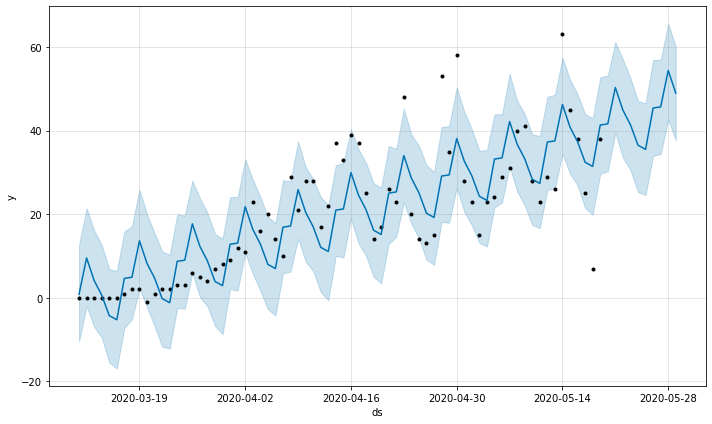

In [22]:
predict_deaths("Texas", 10)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2020-04-30 00:00:00 and 2020-05-12 00:00:00


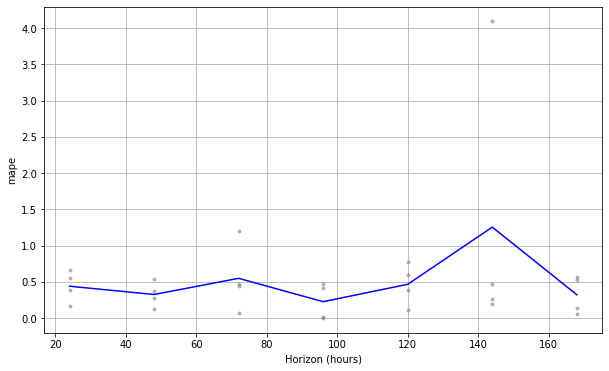

In [23]:
cv_deaths("Texas")

In [35]:
state = "New York"
state_str = state.replace(' ', "%20")

df = pd.read_json(f"http://api-pc6dbtrtla-uc.a.run.app/API/us/timeseries/totals/{state_str}")
df = df.rename(columns={'Totals as of Date': 'Date'})
df['Date'] = pd.to_datetime(df['Date']).dt.date
df['NewCases'] = df['Cases'] - df['Cases'].shift(1)

df_cases = df.loc[df["Date"]>=datetime.date(2020,4,1)]
df_cases = df_cases[["Date", "NewCases"]].rename(columns={"Date": "ds", "NewCases": "y"})

prophet = Prophet()
prophet.fit(df_cases)

future = prophet.make_future_dataframe(periods=10)
forecast = prophet.predict(future)
df_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

df_forecast = df_forecast.assign(yhat = lambda df: df['yhat'].apply(lambda e: max(0, e))).assign(yhat_lower = lambda df: df['yhat_lower'].apply(lambda e: max(0, e))).assign(yhat_upper = lambda df: df['yhat_upper'].apply(lambda e: max(0, e)))

df_forecast

# fig_forecast = prophet.plot(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
0,2020-04-01,10487.404655,8943.539874,12101.105282
1,2020-04-02,10391.607649,8848.216115,11888.893717
2,2020-04-03,10593.827986,9007.761106,12155.953228
3,2020-04-04,10740.079700,9238.986705,12243.601884
4,2020-04-05,9311.292931,7707.634307,10812.934650
5,2020-04-06,8320.464136,6865.047140,9863.938800
6,2020-04-07,8161.148066,6628.344105,9827.819656
7,2020-04-08,9134.532323,7490.158749,10701.610595
8,2020-04-09,9038.735316,7545.472139,10636.057142
9,2020-04-10,9240.955654,7735.304402,10906.808897
